In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
from collections import Counter
import pickle
import argparse
import torch
import sys
from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, DistributedSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


sys.path.insert(0, '..')
from train_binary_cl import (
    get_args_parser,
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    RegionSpecNegAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    plot_sample,
    seed_everything,
)

from models.binary_classifier import build as build_model, obtain_predictions_ground_truth, calc_metrics
import util.misc as utils
import util.box_ops as box_ops

if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_files_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')
ufold_dir = os.path.join(ROOT_DIR, 'UFold_dependencies')
ufold_path= os.path.join(ufold_dir, 'models', 'ufold_train_alldata.pt')
bert_pretrained_dir = os.path.join(ROOT_DIR, 'dataset', 'pre_trained_DNABERT', '6-new-12w-0')

parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()
args.output_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl')
args.dataset_path = os.path.join(ROOT_DIR, 'dataset')
args.device = 'cuda:0'
args.resume = args.resume.replace('checkpoint.pth', 'best_model.pth')

seed_everything(12334)

df = pd.read_csv(os.path.join(processed_files_dir,"df_cdna.csv"))

sys.path.insert(0, ufold_dir)
from UFold_dependencies.running_ufold import UFoldModel
from util.xai import lime, plot_matrix, get_cdna_slices, forward_func, expl_matrix_treshold, cosine_similarity_expl, estimate_bbox
UFoldFeatureExtractor = UFoldModel(args.device, ufold_path, eval_mode = True)

==========Start Loading Pretrained Model==========
==========Finish Loading Pretrained Model==========


In [4]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    output_dir = Path(args.output_dir)

if os.path.isfile(os.path.join(args.output_dir, 'checkpoint.pth')):
    args.resume = os.path.join(args.output_dir, 'checkpoint.pth')
    
    
pos_width_multipliers = {4: 0.05, 10: 0.1, 
                         14: 0.15, 17: 0.1, 
                         19: 0.3, 21: 0.3}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(50, 150): 0.05, (150, 170): 0.12,
                     (170, 260): 0.05, (260, 350): 0.15,
                     (350, 450): 0.28, (450, 511): 0.1,
                     (511, 512): 0.25}
neg_height_windows = neg_width_windows
regionspec_multipliers = pos_width_multipliers
regionspec_windows = neg_width_windows
    
policies_val = [
    EasyPosAugment(
        per_sample=6,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    HardPosAugment(
        per_sample=2,
        interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
        min_width_overlap=0.3,
        min_height_overlap=0.3,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

In [5]:
dataset_val = RNADataset(
        gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
            interactions_path=os.path.join(
                processed_files_dir, "df_annotation_files_cleaned.csv"
            ),
            dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
            subset_file=os.path.join(
                rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"
            ),
        augment_policies=policies_val
    )

device = torch.device(args.device)
model, criterion, postprocessors = build_model(args, bert_pretrained_dir, ufold_path)
model.to(device)
model_without_ddp = model

checkpoint = torch.load(args.resume, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'])

/tmp/ipykernel_29956/2701000778.py:1: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_val = RNADataset(


<All keys matched successfully>

In [6]:
def gradcam(model, rna1, rna2, counterfactual = False):
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(rna1, rna2).detach()
    if counterfactual:
        for i in range(32):
            activations[:, i, :, :] *= - pooled_gradients[i]
    else:
        for i in range(32):
            activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    #heatmap /= torch.max(heatmap)
    heatmap = np.array(heatmap.cpu().squeeze())
    return heatmap

In [7]:
def interpolate_expl_matrix(expl_matrix, height, width, normalize = True):
    im = Image.fromarray(expl_matrix)
    im = im.resize((height, width))
    expl_matrix_reshaped = np.array(im)
    if normalize: 
        expl_matrix_reshaped = (expl_matrix_reshaped - expl_matrix_reshaped.min())/(expl_matrix_reshaped.max() - expl_matrix_reshaped.min())
    return expl_matrix_reshaped

In [8]:
def collect_metrics_and_prediction(matrix , x1, x2, y1, y2, desired_dim = 45):
    cos_sim = float(np.round(cosine_similarity_expl(matrix, [x1, x2, y1, y2]), 3))
    x1hat, y1hat, what, hhat = estimate_bbox(matrix, desired_dim = desired_dim)
    iou_value = float(np.round(box_ops.iou_metric([x1hat, y1hat, what, hhat], 
                                                  [x1, y1, w, h]), 
                               2))
    return cos_sim, iou_value, x1hat, y1hat, what, hhat

In [ ]:
treshold = 70
save = True

filename = os.path.join(processed_files_dir, 'gradcam_results.txt')

row = ['gene1', 'gene2', 'policy', 'x1', 'x2', 'y1', 'y2', 
       'gene1_specie', 'gene1_protein_coding', 'gene1_length', 
       'gene2_specie', 'gene2_protein_coding', 'gene2_length', 
       'int_box_x1', 'int_box_x2', 'int_box_y1', 'int_box_y2',
       'box_x1_hat', 'box_x2_hat', 'box_w_hat', 'box_h_hat',
       'box_x1_hat_tr', 'box_x2_hat_tr', 'box_w_hat_tr', 'box_h_hat_tr',
       'box_x1_hat_con', 'box_x2_hat_con', 'box_w_hat_con', 'box_h_hat_con',
       'box_x1_hat_tr_con', 'box_x2_hat_tr_con', 'box_w_hat_tr_con', 'box_h_hat_tr_con',
       'cos_sim', 'iou_value', 'cos_sim_tr', 'iou_value_tr',
       'cos_sim_con', 'iou_value_con', 'cos_sim_tr_con', 'iou_value_tr_con',
       'cos_sim_rand', 'iou_value_rand', 'cos_sim_rand_tr', 'iou_value_rand_tr',
       'probability'
      ]
if save:
    with open(f'{filename}', 'a') as the_file:
        line = ' '.join(row) + '\n'
        the_file.write(line)
        the_file.close()

model.eval()
criterion.eval()
probs = []
for s in tqdm(dataset_val):
    real = 1 if s.interacting else 0 #, 'easypos'
    if real == 1:
        samples, targets = utils.collate_fn([s])
        rna1, rna2 = samples
        rna1[0] = rna1[0].to(device)
        rna2[0] = rna2[0].to(device)
        rna1[1].tensors = rna1[1].tensors.to(device)
        rna2[1].tensors = rna2[1].tensors.to(device)
        rna1[1].mask = rna1[1].mask.to(device)
        rna2[1].mask = rna2[1].mask.to(device)
        outputs = model(rna1, rna2)
        probability = outputs['cnn_output'].softmax(-1)[:, 1]
        probability = float(np.round(probability.cpu().detach().numpy(), 4))
        probs.append(probability)
        if (float(probability)>0.5):
            outputs['cnn_output'][:, 1].backward()

            s_bbox = s.bbox
            int_bbox = s.seed_interaction_bbox
            x1 = int(int_bbox.x1-s_bbox.x1)
            x2 = int(int_bbox.x2-s_bbox.x1)
            y1 = int(int_bbox.y1-s_bbox.y1)
            y2 = int(int_bbox.y2-s_bbox.y1)
            w = x2-x1
            h = y2-y1
            width = s_bbox.x2-s_bbox.x1
            height = s_bbox.y2-s_bbox.y1
            cdna1_slice, cdna2_slice = get_cdna_slices(s)

            expl_matrix = gradcam(model, rna1, rna2, counterfactual = False)
            expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height, width)
            expl_matrix_tr = expl_matrix_treshold(expl_matrix_reshaped, treshold = treshold, normalize = True)
            cos_sim, iou_value, x1hat, y1hat, what, hhat = collect_metrics_and_prediction(expl_matrix_reshaped, x1, x2, y1, y2)
            cos_sim_tr, iou_value_tr, x1hat_tr, y1hat_tr, what_tr, hhat_tr = collect_metrics_and_prediction(expl_matrix_tr, x1, x2, y1, y2)

            expl_matrix_con = gradcam(model, rna1, rna2, counterfactual = True)
            expl_matrix_reshaped_con = interpolate_expl_matrix(expl_matrix_con, height, width)
            expl_matrix_tr_con = expl_matrix_treshold(expl_matrix_reshaped_con, treshold = treshold, normalize = True)
            cos_sim_con, iou_value_con, x1hat_con, y1hat_con, what_con, hhat_con = collect_metrics_and_prediction(expl_matrix_reshaped_con, x1, x2, y1, y2)
            cos_sim_tr_con, iou_value_tr_con, x1hat_tr_con, y1hat_tr_con, what_tr_con, hhat_tr_con = collect_metrics_and_prediction(expl_matrix_tr_con, x1, x2, y1, y2)

            random_expl_matrix = np.random.rand(expl_matrix_tr.shape[0], expl_matrix_tr.shape[1])
            random_expl_matrix_tr = expl_matrix_treshold(random_expl_matrix, treshold = treshold, normalize = True)
            cos_sim_rand, iou_value_rand, x1hat_rand, y1hat_rand, what_rand, hhat_rand = collect_metrics_and_prediction(random_expl_matrix, x1, x2, y1, y2)
            cos_sim_rand_tr, iou_value_rand_tr, x1hat_rand_tr, y1hat_rand_tr, what_rand_tr, hhat_rand_tr = collect_metrics_and_prediction(random_expl_matrix_tr, x1, x2, y1, y2)

            row = [s.gene1, s.gene2, s.policy, 
                   s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2, s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2,
                   s.gene1_info['species'], s.gene1_info['protein_coding'], s.gene1_info['length'],
                   s.gene2_info['species'], s.gene2_info['protein_coding'], s.gene2_info['length'],
                   s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2, s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2,
                   x1hat, y1hat, what, hhat,
                   x1hat_tr, y1hat_tr, what_tr, hhat_tr,
                   x1hat_con, y1hat_con, what_con, hhat_con,
                   x1hat_tr_con, y1hat_tr_con, what_tr_con, hhat_tr_con,
                   cos_sim, iou_value, cos_sim_tr, iou_value_tr,
                   cos_sim_con, iou_value_con, cos_sim_tr_con, iou_value_tr_con,
                   cos_sim_rand, iou_value_rand, cos_sim_rand_tr, iou_value_rand_tr,
                   probability
                  ]
            row = [str(i) for i in row]
            if save:
                with open(f'{filename}', 'a') as the_file:
                    line = ' '.join(row) + '\n'
                    the_file.write(line)
                    the_file.close()

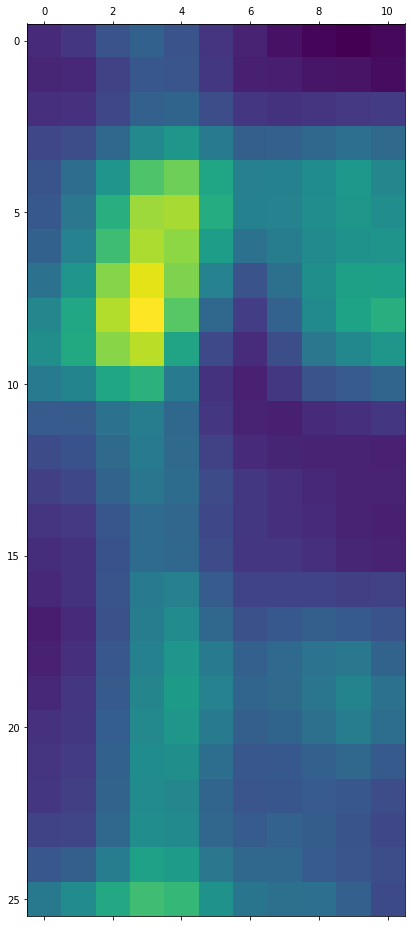

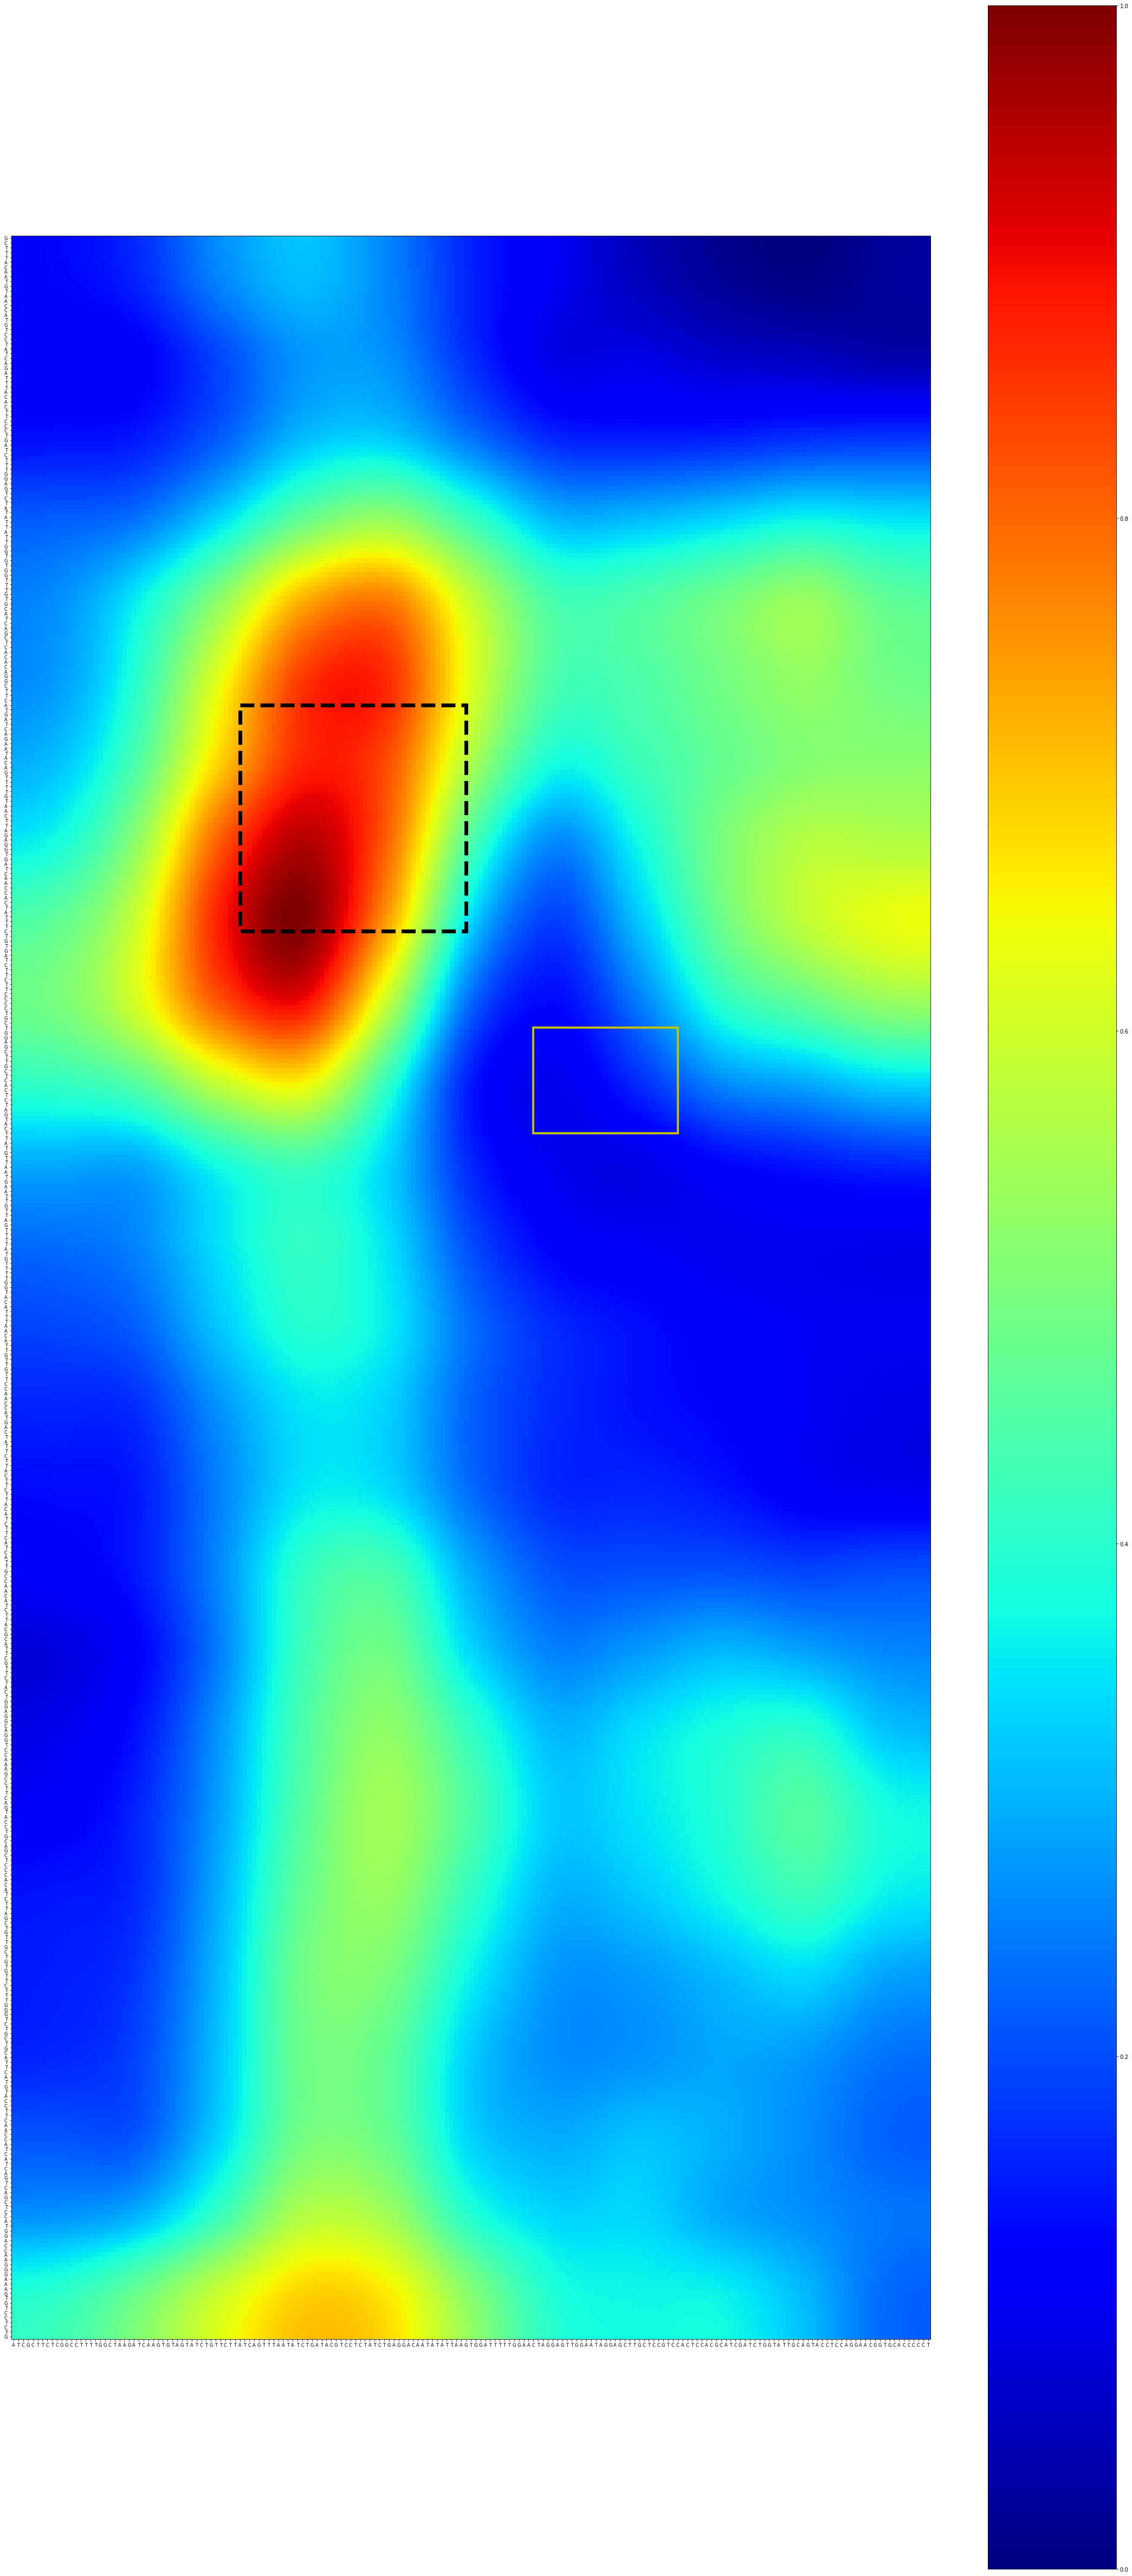

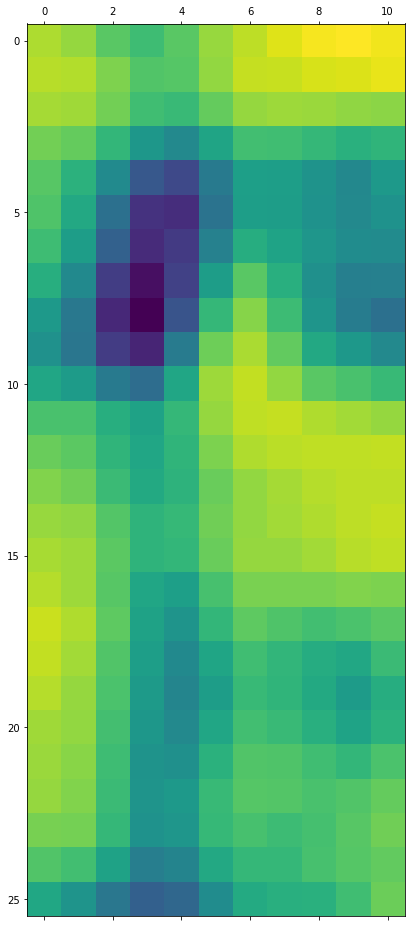

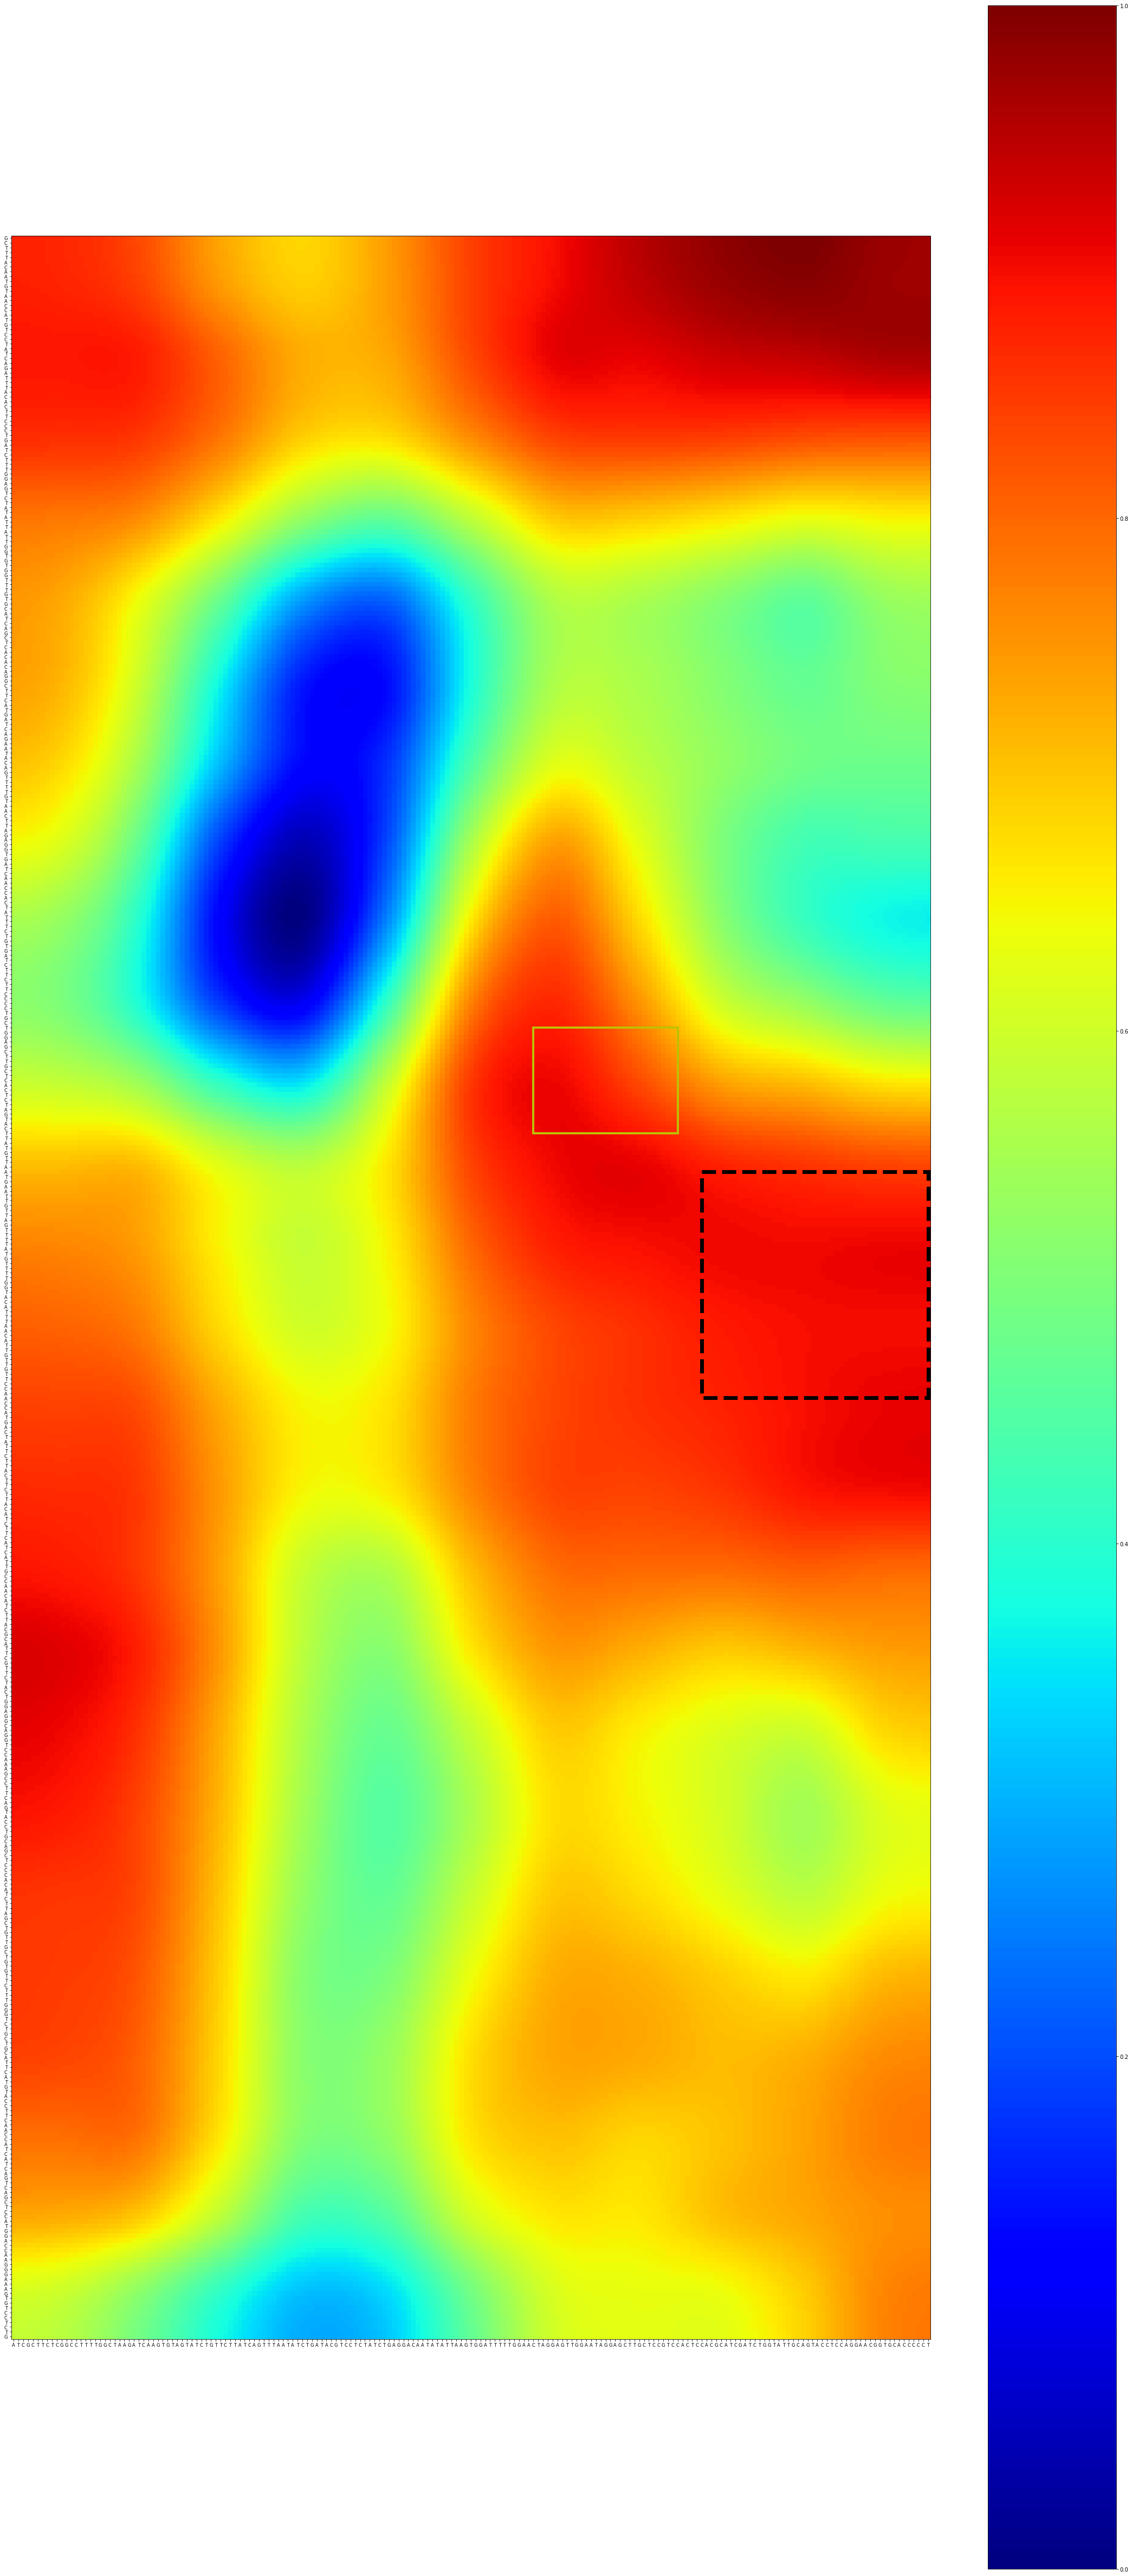

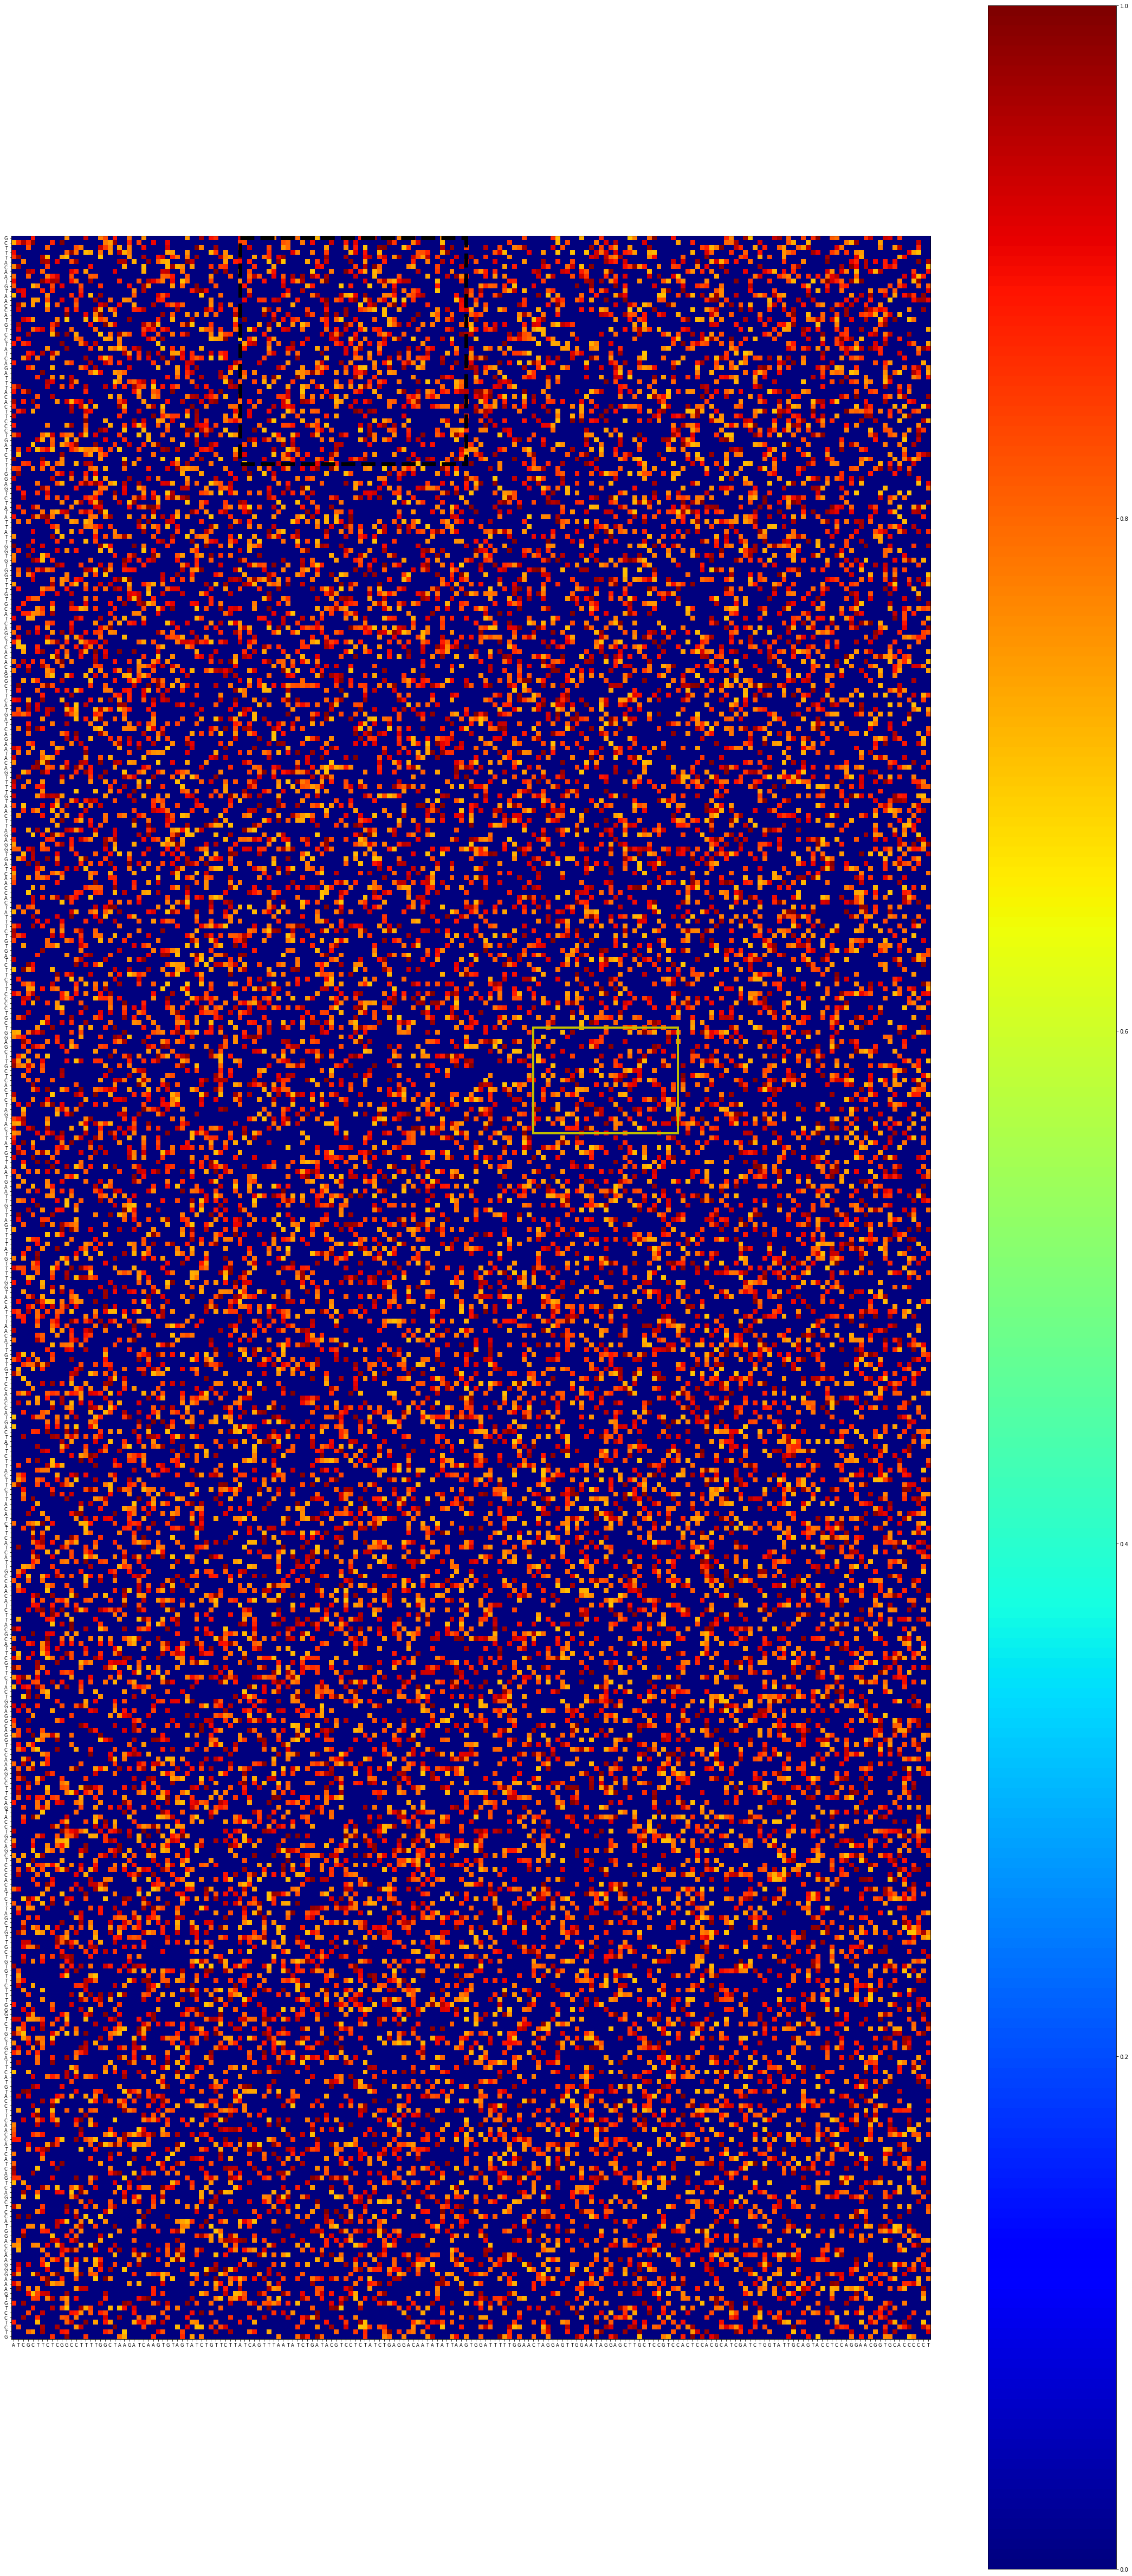

In [15]:
plt.matshow(expl_matrix.T)
plt.show()
plot_matrix(expl_matrix_reshaped, cdna1_slice, cdna2_slice, [[x1, y1, w, h]], crop_bbox =[x1hat, y1hat, what, hhat], cmap ='jet')
plt.show()
plt.matshow(expl_matrix_con.T)
plt.show()
plot_matrix(expl_matrix_reshaped_con, cdna1_slice, cdna2_slice, [[x1, y1, w, h]], crop_bbox =[x1hat_con, y1hat_con, what_con, hhat_con], cmap ='jet')
plt.show()
plot_matrix(random_expl_matrix_tr, cdna1_slice, cdna2_slice, [[x1, y1, w, h]], crop_bbox = [x1hat_rand_tr, y1hat_rand_tr, what_rand_tr, hhat_rand_tr], cmap ='jet')
plt.show()

# Read results 

In [16]:
res = pd.read_csv(os.path.join(processed_files_dir, 'gradcam_results.txt'), sep = ' ')

### IOU

In [17]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_con', 'iou_value_tr_con', 'iou_value_rand', 'iou_value_rand_tr']
for c in iou_columns:
    print(f'{c}: {str(np.round(res[c].mean(), 2))}')

iou_value: 0.02
iou_value_tr: 0.02
iou_value_con: 0.01
iou_value_tr_con: 0.01
iou_value_rand: 0.02
iou_value_rand_tr: 0.02


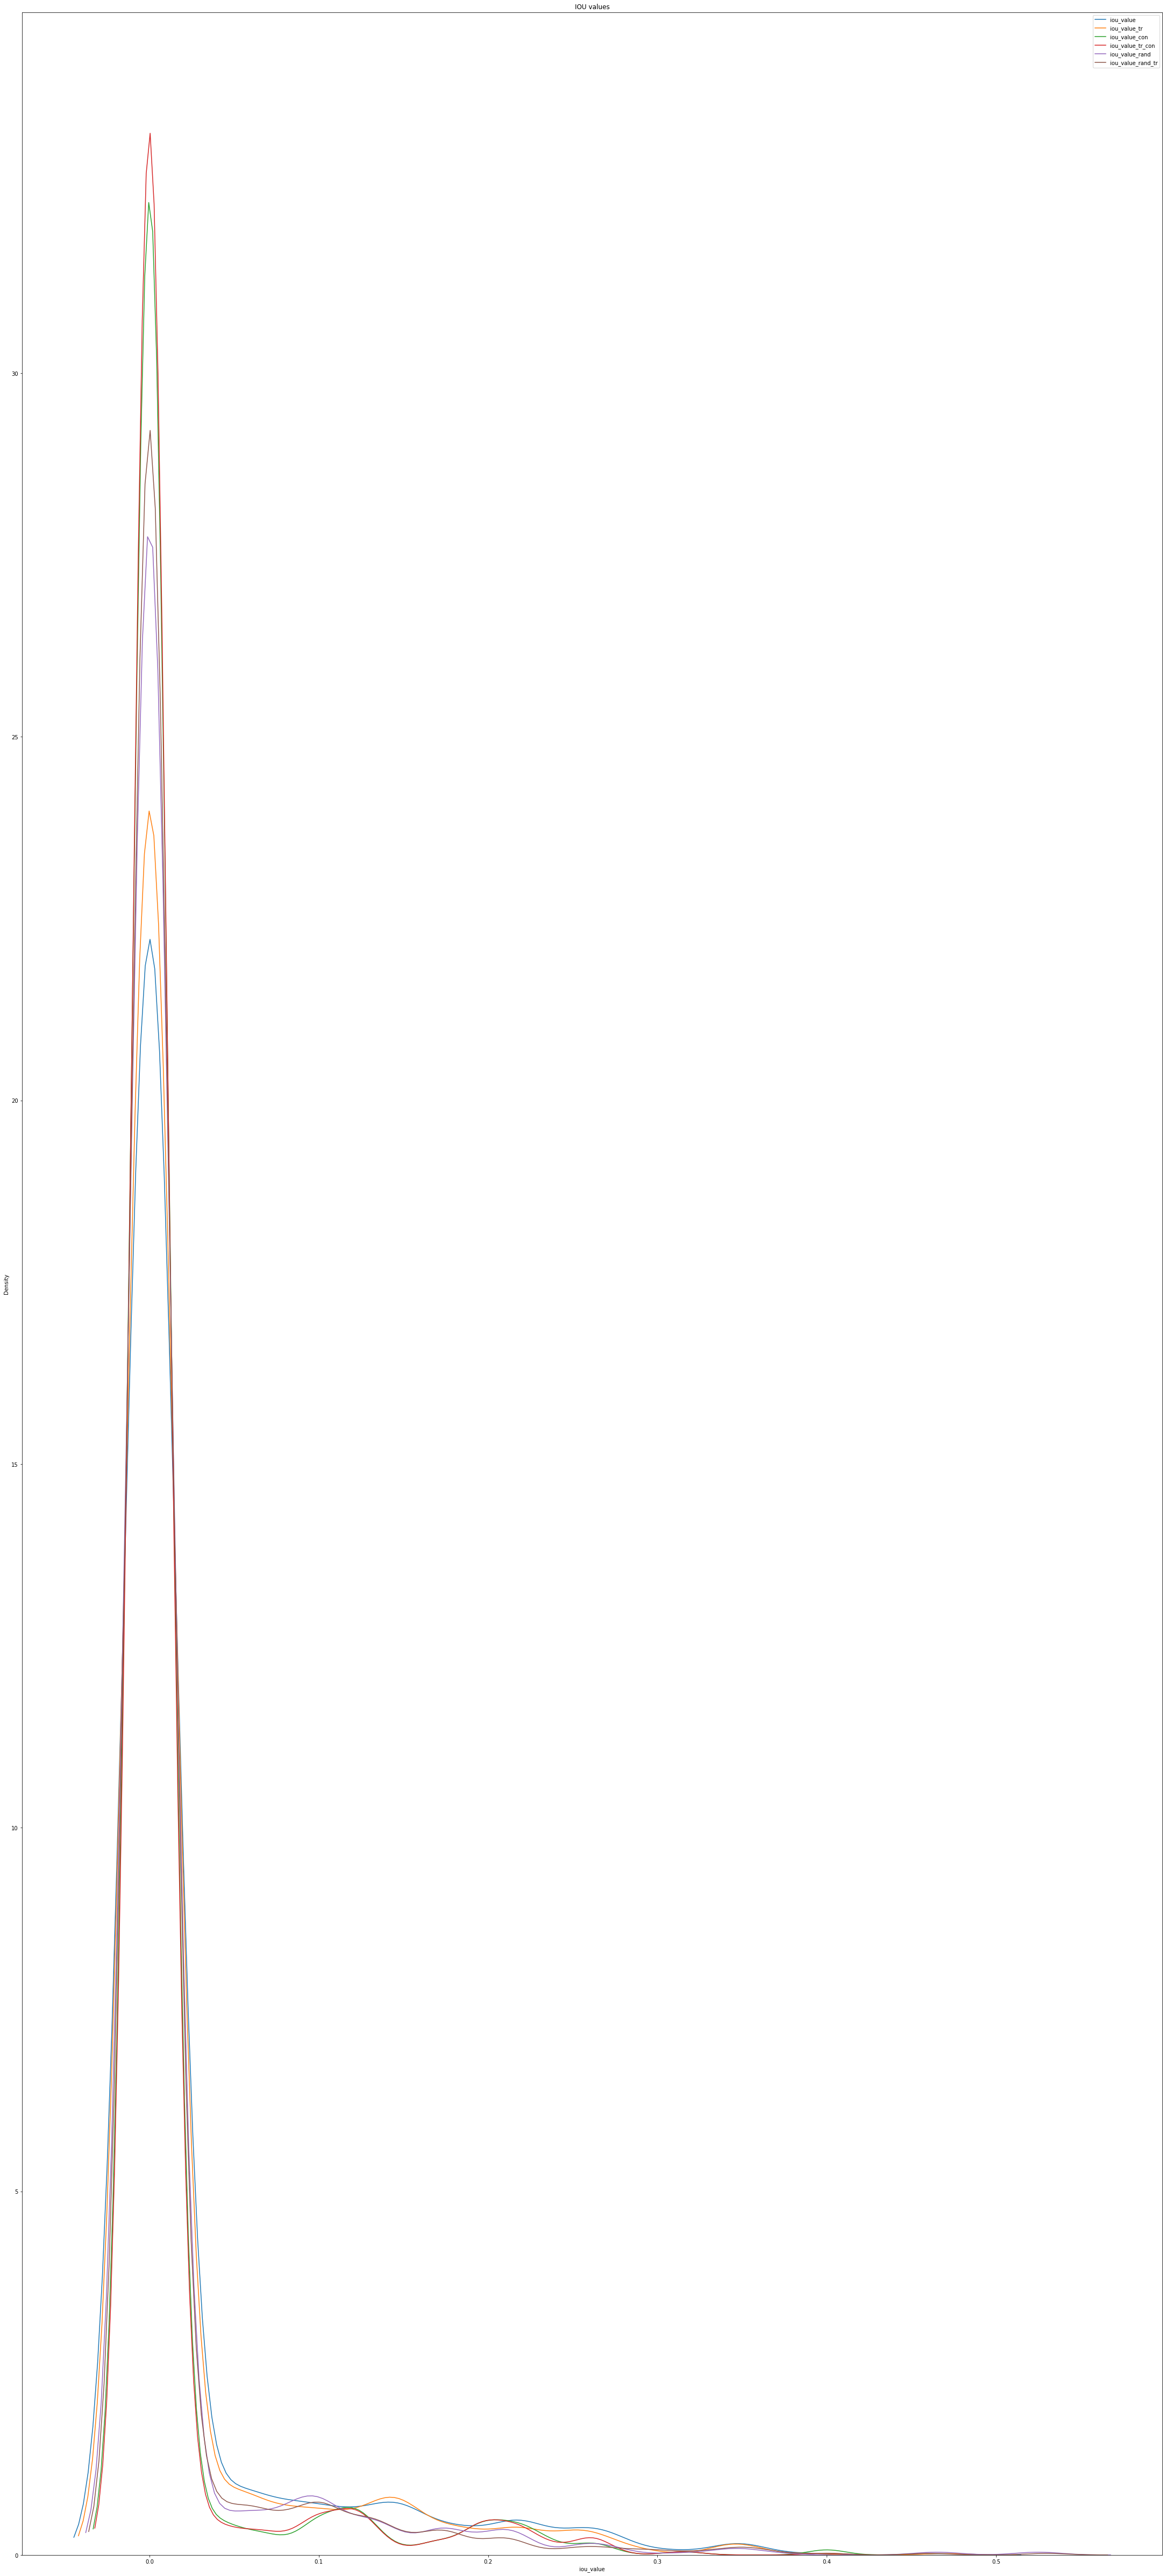

In [18]:
for c in iou_columns:
    sns.kdeplot(res[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

### Cosine similarity

In [19]:
cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_con', 'cos_sim_tr_con', 'cos_sim_rand', 'cos_sim_rand_tr']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(res[c].mean(), 2))}')

cos_sim: 0.12
cos_sim_tr: 0.08
cos_sim_con: 0.1
cos_sim_tr_con: 0.05
cos_sim_rand: 0.1
cos_sim_rand_tr: 0.06


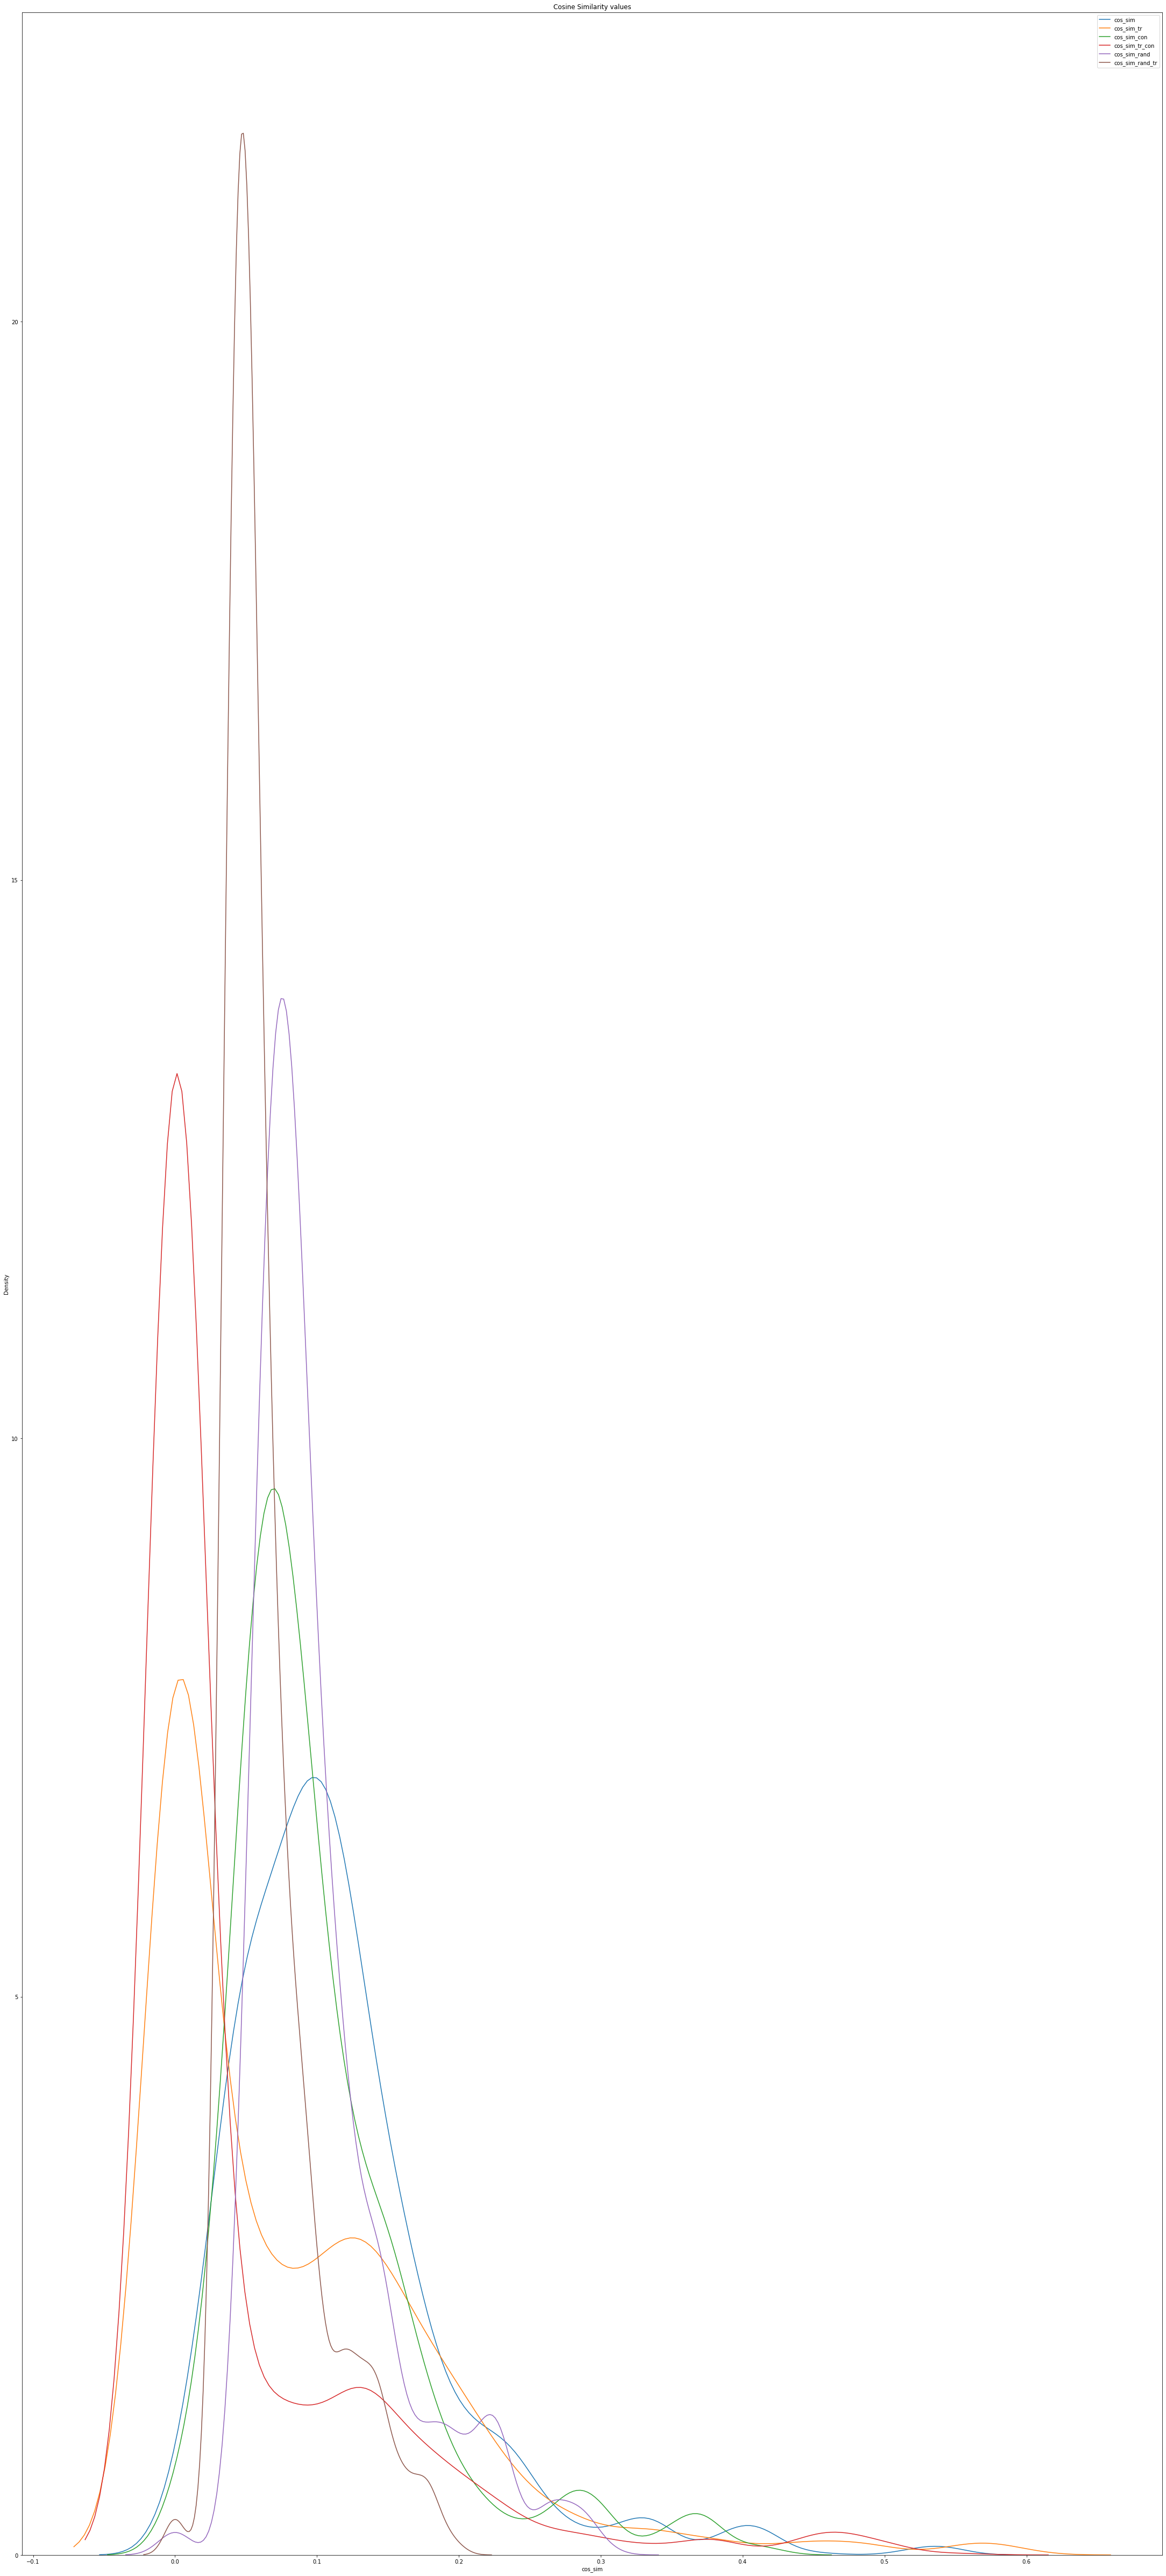

In [20]:
for c in cosine_sim_columns:
    sns.kdeplot(res[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()